In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing of Oversample Data

In [2]:
over_dataframe= pd.read_csv('oversample.csv')

In [3]:
over_dataframe.head

<bound method NDFrame.head of        Unnamed: 0.1  Unnamed: 0  listing_id           id        date  \
0                 0           0     50646.0   11909864.0   18/4/2014   
1                 1           1     50646.0   13823948.0    5/6/2014   
2                 2           2     50646.0   15117222.0    2/7/2014   
3                 3           3     50646.0   15426462.0    8/7/2014   
4                 4           4     50646.0   15552912.0   11/7/2014   
...             ...         ...         ...          ...         ...   
73049         12195       14107   9563744.0  188889670.0   31/8/2017   
73050         26045       30149  24170288.0  292800518.0   19/7/2018   
73051          2661        2994   3859180.0  219598702.0  18/12/2017   
73052          3599        4049   4380000.0  573723009.0   7/12/2019   
73053         19647       22882  16522880.0  230798056.0   29/1/2018   

       reviewer_id reviewer_name  \
0        1356099.0         James   
1       15222393.0         Welli 

In [4]:
def tweet_to_words(comment):
    ''' Convert tweet text into a sequence of words '''
    # convert to lowercase
    text = comment.lower()
    # tokenize
    words = text.split()
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words



In [5]:
X = list(map(tweet_to_words, over_dataframe['comments_nostop']))

In [6]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(over_dataframe['bin_word'])

In [7]:
over_dataframe['bin_word']                                   

0        VP
1        VP
2        VP
3        VP
4        VP
         ..
73049     N
73050    VN
73051    QN
73052    QN
73053    VN
Name: bin_word, Length: 73054, dtype: object

In [8]:
print(X[0])
print(Y[0])

['a', 'comfort', 'room', 'smart', 'condo', 'develop', 'everyth', 'kept', 'clean', 'i', 'use', 'bathroom', 'sujatha', 'husband', 'great', 'host', 'friendli', 'accommod', 'ill', 'stay']
5


In [9]:
y = pd.get_dummies(over_dataframe['bin_word'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary_size = 800
#  have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [11]:
print(count_vector.get_feature_names()[0:200])

["'", 'a', 'abl', 'absolut', 'ac', 'access', 'accommod', 'accomod', 'accur', 'across', 'actual', 'addit', 'address', 'adult', 'advertis', 'afford', 'after', 'agre', 'air', 'airbnb', 'aircon', 'aircondit', 'airport', 'alex', 'aljuni', 'all', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'although', 'alvin', 'alway', 'amaz', 'amen', 'and', 'anoth', 'answer', 'ant', 'anyon', 'anyth', 'anywher', 'apart', 'appreci', 'area', 'around', 'arrang', 'arriv', 'as', 'ask', 'assist', 'at', 'atmospher', 'attach', 'attract', 'avail', 'avoid', 'away', 'awesom', 'back', 'backpack', 'bad', 'balconi', 'bar', 'bare', 'base', 'basic', 'bath', 'bathroom', 'bay', 'be', 'beauti', 'bed', 'bedroom', 'believ', 'belong', 'benni', 'besid', 'best', 'better', 'big', 'bigger', 'bit', 'blanket', 'block', 'bnb', 'boat', 'book', 'bother', 'bottl', 'breakfast', 'bring', 'broken', 'bu', 'budget', 'bug', 'bugi', 'build', 'bunk', 'buse', 'busi', 'but', 'buy', 'cafe', 'call', 'came', 'cancel', 'cannot', 'cant', 'caps

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


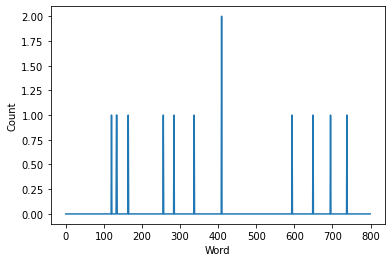

In [12]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 800
max_len= 200

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', over_dataframe['comments_nostop'][0])
X, tokenizer = tokenize_pad_sequences(over_dataframe['comments_nostop'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 A COMFORTABLE ROOM SMART CONDO DEVELOPMENT EVERYTHING KEPT CLEAN I USE BATHROOM SUJATHA HUSBAND GREAT HOSTS FRIENDLY ACCOMMODATING ILL STAYING 
After Tokenization & Padding 
 [110  42   4 473  43 477   9   1  88  31 707   8 190  58 296 640  67   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [14]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
y = pd.get_dummies(over_dataframe['bin_word'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (43832, 200) (43832, 6)
Validation Set -> (14611, 200) (14611, 6)
Test Set -> (14611, 200) (14611, 6)


In [16]:
back_up_X_train = X_train
back_up_y_train =  y_train
back_up_X_test =  X_test
back_up_y_test = y_test


In [17]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Model 1 (vocab_size = 800, embedding_size = 32, epochs=25,batch_size = 64)

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 800
embedding_size = 32
epochs= 25
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


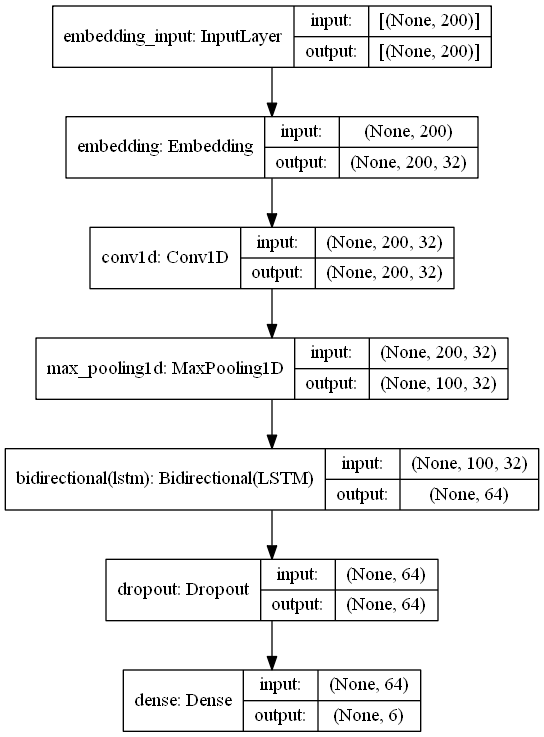

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           25600     
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
____________________________________________________

In [21]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9212
Precision : 0.9309
Recall    : 0.9158
F1 Score  : 0.9233


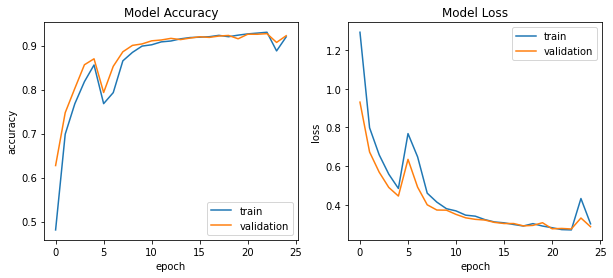

In [22]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

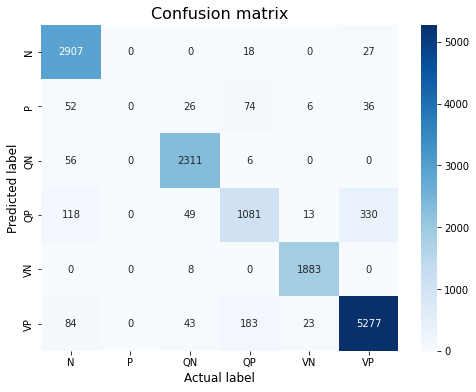

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    sentiment_classes = ['N', 'P', 'QN','QP','VN','VP']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [24]:
# Save the model architecture & the weights
model.save('model1.h5')
print('Best model saved')

Best model saved


In [25]:
##new_predicted = y_pred = model.predict(X_test)
##new_predicted =np.argmax(np.array(new_predicted),axis=1)
##new_predicted=pd.DataFrame(new_predicted, columns=['predicted'])  


##def convertertotag(x):
  #  if x==0:   return 'N'
   # if x==1:   return 'P'
    #if x==2:   return 'QN'
   # if x==3:   return 'QP'
   # if x==4:   return 'VN'
    #if x==5:   return 'VP'
    
#new_predicted['predicted_tag'] = new_predicted['predicted'].apply(convertertotag)
#tempdf = new_predicted['predicted_tag']

## Model 2 (vocab_size = 800, embedding_size = 32, epochs=50,batch_size = 64)

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size_2 = 800
embedding_size_2 = 32
epochs_2= 50
learning_rate_2 = 0.1
decay_rate_2 = learning_rate_2 / epochs_2
momentum_2 = 0.8

sgd2 = SGD(lr=learning_rate_2, momentum=momentum_2, decay=decay_rate_2, nesterov=False)
# Build model
model2= Sequential()
model2.add(Embedding(vocab_size_2, embedding_size_2, input_length=max_len))
model2.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.4))
model2.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
print(model2.summary())
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer=sgd2, 
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size_2 = 64
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size_2, epochs=epochs_2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           25600     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
__________________________________________________

Epoch 31/50
685/685 [==============================] - 13s 18ms/step - loss: 0.1785 - accuracy: 0.9462 - precision_1: 0.9534 - recall_1: 0.9404 - val_loss: 0.2069 - val_accuracy: 0.9385 - val_precision_1: 0.9442 - val_recall_1: 0.9355
Epoch 32/50
685/685 [==============================] - 13s 18ms/step - loss: 0.1755 - accuracy: 0.9469 - precision_1: 0.9538 - recall_1: 0.9409 - val_loss: 0.2065 - val_accuracy: 0.9387 - val_precision_1: 0.9458 - val_recall_1: 0.9333
Epoch 33/50
685/685 [==============================] - 13s 18ms/step - loss: 0.1745 - accuracy: 0.9476 - precision_1: 0.9549 - recall_1: 0.9415 - val_loss: 0.2014 - val_accuracy: 0.9396 - val_precision_1: 0.9465 - val_recall_1: 0.9353
Epoch 34/50
685/685 [==============================] - 13s 19ms/step - loss: 0.1752 - accuracy: 0.9475 - precision_1: 0.9550 - recall_1: 0.9416 - val_loss: 0.2035 - val_accuracy: 0.9400 - val_precision_1: 0.9457 - val_recall_1: 0.9364
Epoch 35/50
685/685 [==============================] - 13s 1

In [28]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model2.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9390
Precision : 0.9438
Recall    : 0.9342
F1 Score  : 0.9390


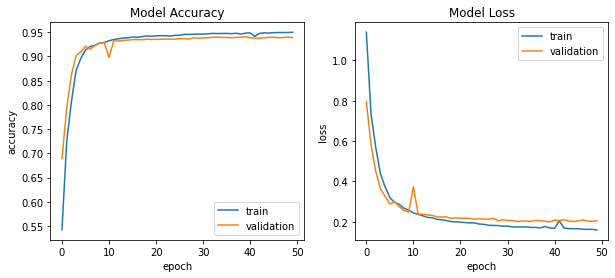

In [29]:
plot_training_hist(history2)

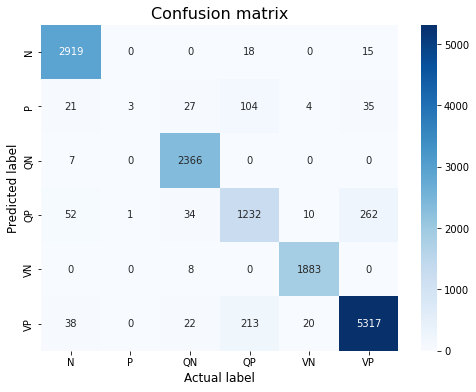

In [30]:
plot_confusion_matrix(model2, X_test, y_test)

In [31]:
# Save the model architecture & the weights
model2.save('model2.h5')
print('Best model saved')

Best model saved


## Model 3 (vocab_size = 800, embedding_size = 32, epochs=75,batch_size = 64)

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size_3 = 800
embedding_size_3 = 32
epochs_3= 75
learning_rate_3 = 0.1
decay_rate_3 = learning_rate_3 / epochs_3
momentum_3 = 0.8

sgd3 = SGD(lr=learning_rate_3, momentum=momentum_3, decay=decay_rate_3, nesterov=False)
# Build model
model3= Sequential()
model3.add(Embedding(vocab_size_3, embedding_size_3, input_length=max_len))
model3.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(LSTM(32)))
model3.add(Dropout(0.4))
model3.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [33]:
print(model3.summary())
# Compile model
model3.compile(loss='categorical_crossentropy', optimizer=sgd3, 
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size_3 = 64
history3 = model3.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size_3, epochs=epochs_3, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           25600     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
__________________________________________________

Epoch 31/75
685/685 [==============================] - 13s 19ms/step - loss: 0.1561 - accuracy: 0.9522 - precision_2: 0.9589 - recall_2: 0.9466 - val_loss: 0.2071 - val_accuracy: 0.9403 - val_precision_2: 0.9457 - val_recall_2: 0.9363
Epoch 32/75
685/685 [==============================] - 13s 18ms/step - loss: 0.1534 - accuracy: 0.9528 - precision_2: 0.9599 - recall_2: 0.9476 - val_loss: 0.1995 - val_accuracy: 0.9416 - val_precision_2: 0.9471 - val_recall_2: 0.9363
Epoch 33/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1512 - accuracy: 0.9523 - precision_2: 0.9594 - recall_2: 0.9470 - val_loss: 0.1892 - val_accuracy: 0.9431 - val_precision_2: 0.9481 - val_recall_2: 0.9387
Epoch 34/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1546 - accuracy: 0.9521 - precision_2: 0.9586 - recall_2: 0.9463 - val_loss: 0.1930 - val_accuracy: 0.9420 - val_precision_2: 0.9474 - val_recall_2: 0.9387
Epoch 35/75
685/685 [==============================] - 13s 1

Epoch 66/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1255 - accuracy: 0.9601 - precision_2: 0.9660 - recall_2: 0.9556 - val_loss: 0.1963 - val_accuracy: 0.9432 - val_precision_2: 0.9470 - val_recall_2: 0.9400
Epoch 67/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1253 - accuracy: 0.9603 - precision_2: 0.9660 - recall_2: 0.9553 - val_loss: 0.1936 - val_accuracy: 0.9436 - val_precision_2: 0.9470 - val_recall_2: 0.9410
Epoch 68/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1240 - accuracy: 0.9602 - precision_2: 0.9656 - recall_2: 0.9556 - val_loss: 0.1935 - val_accuracy: 0.9442 - val_precision_2: 0.9469 - val_recall_2: 0.9406
Epoch 69/75
685/685 [==============================] - 12s 18ms/step - loss: 0.1255 - accuracy: 0.9610 - precision_2: 0.9671 - recall_2: 0.9562 - val_loss: 0.1958 - val_accuracy: 0.9435 - val_precision_2: 0.9475 - val_recall_2: 0.9405
Epoch 70/75
685/685 [==============================] - 13s 1

In [34]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9395
Precision : 0.9434
Recall    : 0.9371
F1 Score  : 0.9403


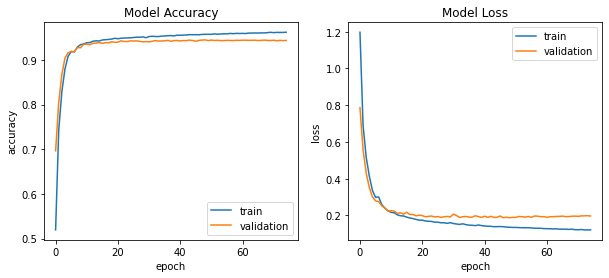

In [35]:
plot_training_hist(history3)

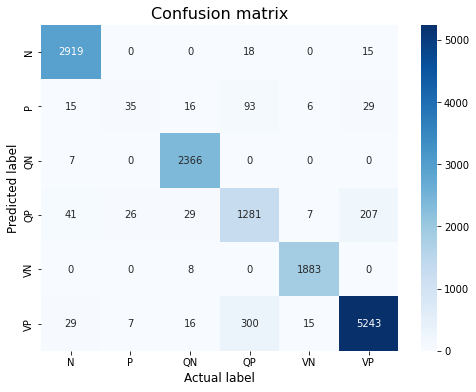

In [36]:
plot_confusion_matrix(model3, X_test, y_test)

In [37]:
# Save the model architecture & the weights
model3.save('model3.h5')
print('Best model saved')

Best model saved


In [38]:
new_predicted = y_pred = model3.predict(X_test)
new_predicted =np.argmax(np.array(new_predicted),axis=1)
new_predicted=pd.DataFrame(new_predicted, columns=['predicted'])  

def convertertotag(x):
    if x==0:   return 'N'
    if x==1:   return 'P'
    if x==2:   return 'QN'
    if x==3:   return 'QP'
    if x==4:   return 'VN'
    if x==5:   return 'VP'
    
new_predicted['predicted_tag'] = new_predicted['predicted'].apply(convertertotag)
tempdf = new_predicted['predicted_tag']

In [39]:
tempdf 

0        VP
1         N
2        VP
3        QN
4        QN
         ..
14606    QP
14607    VP
14608    VP
14609    QN
14610    VP
Name: predicted_tag, Length: 14611, dtype: object

## Model 4 (vocab_size = 800, embedding_size = 32, epochs=75,batch_size = 32)

In [40]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size_4 = 800
embedding_size_4 = 32
epochs_4= 75
learning_rate_4 = 0.1
decay_rate_4 = learning_rate_4 / epochs_4
momentum_4 = 0.8

sgd4 = SGD(lr=learning_rate_4, momentum=momentum_4, decay=decay_rate_4, nesterov=False)
# Build model
model4= Sequential()
model4.add(Embedding(vocab_size_4, embedding_size_4, input_length=max_len))
model4.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Bidirectional(LSTM(32)))
model4.add(Dropout(0.4))
model4.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
print(model4.summary())
# Compile model
model4.compile(loss='categorical_crossentropy', optimizer=sgd4, 
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size_4 = 32
history4 = model4.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size_4, epochs=epochs_4, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           25600     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
__________________________________________________

Epoch 31/75
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1480 - accuracy: 0.9533 - precision_3: 0.9602 - recall_3: 0.9475 - val_loss: 0.2065 - val_accuracy: 0.9379 - val_precision_3: 0.9439 - val_recall_3: 0.9334
Epoch 32/75
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1466 - accuracy: 0.9536 - precision_3: 0.9607 - recall_3: 0.9475 - val_loss: 0.1951 - val_accuracy: 0.9396 - val_precision_3: 0.9444 - val_recall_3: 0.9366
Epoch 33/75
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1465 - accuracy: 0.9528 - precision_3: 0.9606 - recall_3: 0.9476 - val_loss: 0.2020 - val_accuracy: 0.9388 - val_precision_3: 0.9444 - val_recall_3: 0.9346
Epoch 34/75
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1446 - accuracy: 0.9530 - precision_3: 0.9604 - recall_3: 0.9473 - val_loss: 0.1898 - val_accuracy: 0.9403 - val_precision_3: 0.9444 - val_recall_3: 0.9372
Epoch 35/75
1370/1370 [=============================

In [42]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model4.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9407
Precision : 0.9445
Recall    : 0.9368
F1 Score  : 0.9406


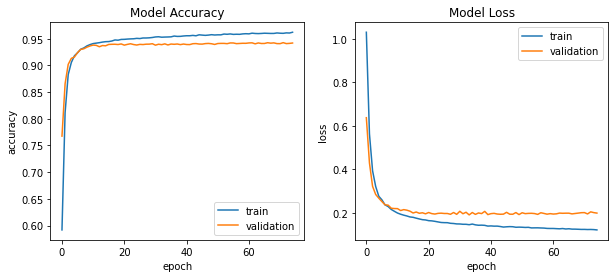

In [43]:
plot_training_hist(history4)

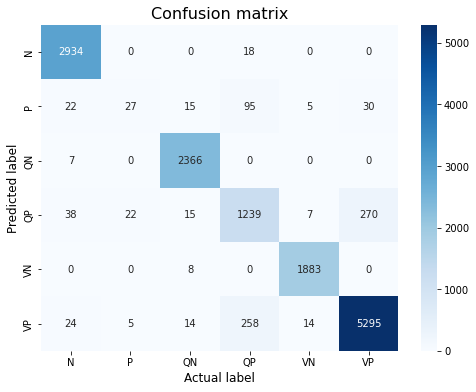

In [44]:
plot_confusion_matrix(model4, X_test, y_test)

In [45]:
# Save the model architecture & the weights
model4.save('model4.h5')
print('Best model saved')

Best model saved


## Model 5 (vocab_size = 800, embedding_size = 32, epochs=50,batch_size = 32)

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size_5 = 800
embedding_size_5 = 32
epochs_5= 50
learning_rate_5 = 0.1
decay_rate_5 = learning_rate_5 / epochs_5
momentum_5 = 0.8

sgd5 = SGD(lr=learning_rate_5, momentum=momentum_5, decay=decay_rate_5, nesterov=False)
# Build model
model5= Sequential()
model5.add(Embedding(vocab_size_5, embedding_size_5, input_length=max_len))
model5.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(32)))
model5.add(Dropout(0.4))
model5.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [47]:
print(model5.summary())
# Compile model
model5.compile(loss='categorical_crossentropy', optimizer=sgd5, 
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size_5 = 32
history5 = model5.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size_5, epochs=epochs_5, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           25600     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
__________________________________________________

Epoch 31/50
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1562 - accuracy: 0.9501 - precision_4: 0.9565 - recall_4: 0.9443 - val_loss: 0.1953 - val_accuracy: 0.9396 - val_precision_4: 0.9450 - val_recall_4: 0.9366
Epoch 32/50
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1559 - accuracy: 0.9509 - precision_4: 0.9576 - recall_4: 0.9449 - val_loss: 0.1990 - val_accuracy: 0.9394 - val_precision_4: 0.9454 - val_recall_4: 0.9354
Epoch 33/50
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1559 - accuracy: 0.9507 - precision_4: 0.9580 - recall_4: 0.9453 - val_loss: 0.1964 - val_accuracy: 0.9400 - val_precision_4: 0.9445 - val_recall_4: 0.9369
Epoch 34/50
1370/1370 [==============================] - 25s 18ms/step - loss: 0.1540 - accuracy: 0.9512 - precision_4: 0.9586 - recall_4: 0.9456 - val_loss: 0.1949 - val_accuracy: 0.9404 - val_precision_4: 0.9455 - val_recall_4: 0.9373
Epoch 35/50
1370/1370 [=============================

In [48]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model5.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9389
Precision : 0.9428
Recall    : 0.9359
F1 Score  : 0.9394


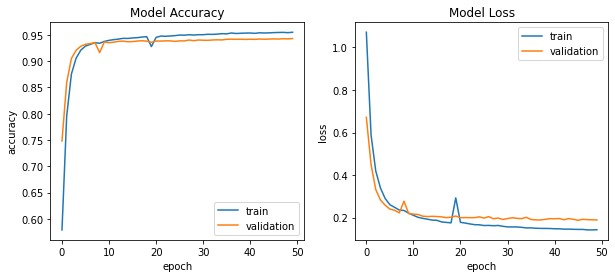

In [49]:
plot_training_hist(history5)

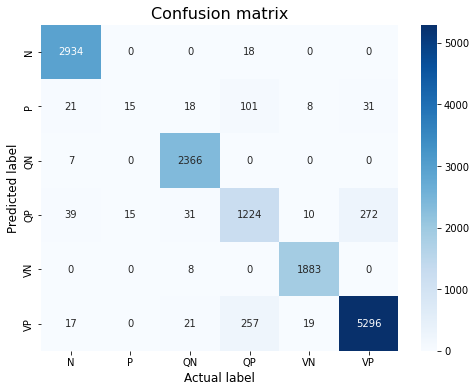

In [50]:
plot_confusion_matrix(model5, X_test, y_test)

In [51]:
# Save the model architecture & the weights
model5.save('model5.h5')
print('Best model saved')

Best model saved


## Model 6 (vocab_size = 800, embedding_size = 32, epochs=25,batch_size = 32)

In [52]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers  import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size_6 = 800
embedding_size_6 = 32
epochs_6= 25
learning_rate_6 = 0.1
decay_rate_6 = learning_rate_6 / epochs_6
momentum_6 = 0.8

sgd6 = SGD(lr=learning_rate_6, momentum=momentum_6, decay=decay_rate_6, nesterov=False)
# Build model
model6= Sequential()
model6.add(Embedding(vocab_size_6, embedding_size_6, input_length=max_len))
model6.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu'))
model6.add(MaxPooling1D(pool_size=2))
model6.add(Bidirectional(LSTM(32)))
model6.add(Dropout(0.4))
model6.add(Dense(6, activation='softmax'))

C:\Users\liang\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [53]:
print(model6.summary())
# Compile model
model6.compile(loss='categorical_crossentropy', optimizer=sgd6, 
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size_6 = 32
history6 = model6.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size_6, epochs=epochs_6, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 32)           25600     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 200, 32)           6176      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 48,806
Trainable params: 48,806
Non-trainable params: 0
__________________________________________________

In [54]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model6.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9320
Precision : 0.9382
Recall    : 0.9279
F1 Score  : 0.9330


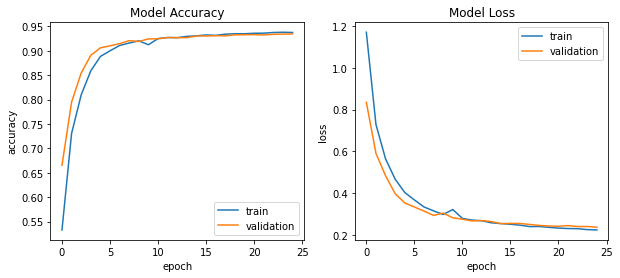

In [55]:
plot_training_hist(history6)

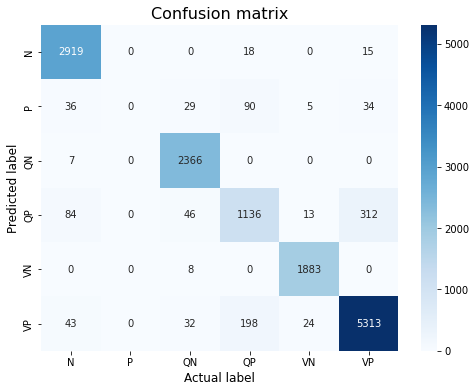

In [56]:
plot_confusion_matrix(model6, X_test, y_test)

In [57]:
# Save the model architecture & the weights
model6.save('model6.h5')
print('Best model saved')

Best model saved


In [58]:
##selected model, model 3 
##1. predict all the class correctly
##2. highest accuracy
##3. low training time

In [59]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Load model
model3 =  load_model('model3.h5')
def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    sentiment_classes = ['N', 'P', 'QN','QP','VN','VP']
    max_len=200
    max_words = 800
    max_len= 200

    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model3.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [60]:
#demo
predict_class(["Very friendly and helpful people, room wasn't clean enough for our expectations. Lousy wifi connection"])

The predicted sentiment is VP
